# Target Sales Analysis

In [1]:
pip install mysql.connector

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r"C:\Users\PMLS\OneDrive\Desktop\Desktop\MAKE IT\SQL\Ecommerce"


def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db= mysql.connector.connect(host="localhost",
                            username="root",
                            password="12345",
                            database="ecommerce")
cur=db.cursor()

## 1. List all unique cities where customers are located.

In [7]:
query="""SELECT DISTINCT Customer_city FROM Customers"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## 2. Count the number of orders placed in 2017.

In [6]:
query= """Select count(order_id) from orders where year (order_purchase_timestamp) =2017"""
cur.execute(query)
data=cur.fetchall()
x=f"The total number of orders in 2017 are: {data[0][0]}"
print(x)

The total number of orders in 2017 are: 135303


## 3. Find the total sales per category.

In [9]:
query= """Select upper(products. product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id= order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["category", "sales"])
df

,category,sales
0,PERFUMERY,1520215.98
1,FURNITURE DECORATION,4290529.18
2,TELEPHONY,1460646.15
3,BED TABLE BATH,5137661.01
4,AUTOMOTIVE,2556882.99
...,...,...
69,CDS MUSIC DVDS,3598.29
70,LA CUISINE,8740.59
71,FASHION CHILDREN'S CLOTHING,2357.01
72,PC GAMER,6523.29


## 4. Calculate the percentage of orders that were paid in installments.

In [10]:
query= """select (sum(case when payment_installments>=1 then 1
else 0 end))/count(*)*100 from payments
"""
cur.execute(query)
data=cur.fetchall()
"The percentage of orders that were paid in instalments is" , data[0][0]

('The percentage of orders that were paid in instalments is',
 Decimal('99.9981'))

## 5. Count the number of customers from each state. 

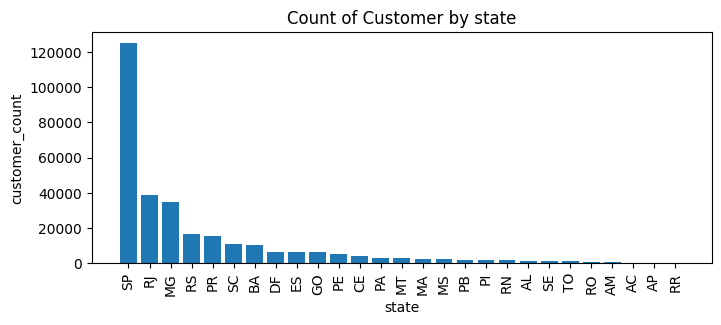

In [11]:
query = """
SELECT customer_state, COUNT(customer_id) 
FROM customers 
GROUP BY customer_state
"""
cur.execute(query)
data = cur.fetchall()
import pandas as pd
df = pd.DataFrame(data, columns=["state", "customer_count"])
df=df.sort_values(by="customer_count", ascending=False)
plt.figure(figsize= (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation=90)
plt.title("Count of Customer by state")
plt.xlabel("state")
plt.ylabel("customer_count")
plt.show()

## 6. Calculate the number of orders per month in 2018.

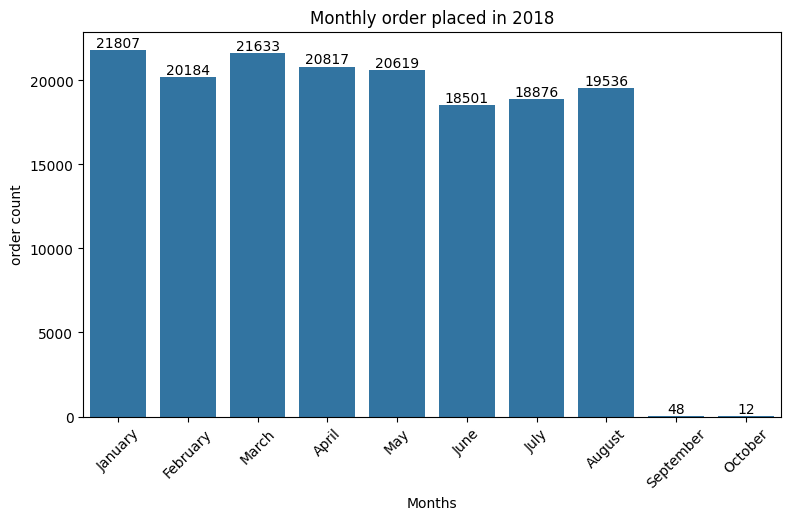

In [12]:
query= """ select monthname(order_purchase_timestamp)months, count(order_id) order_count
from orders where year(order_purchase_timestamp)= 2018
group by months"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Months","order count"])
o=["January", "February", "March","April","May","June","July","August","September","October"]
plt.figure(figsize=(9, 5))
ax= sns.barplot(x=df["Months"],y=df["order count"],data= df,order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Monthly order placed in 2018")
plt.show()

## 7. Find the average number of products per order, grouped by customer city.

In [7]:
query= """ WITH count_per_order AS (
    SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc), 2) average_orders
FROM customers
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city order by average_orders desc
"""
cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data,columns=["customer_city","average products/order"])
df.head(5)


,customer_city,average products/order
0,padre carvalho,21.00
1,celso ramos,19.50
2,datas,18.00
3,candido godoi,18.00
4,matias olimpio,15.00


## 8. Calculate the percentage of total revenue contributed by each product category.

In [14]:
query="""SELECT 
    UPPER(products.product_category) AS category, 
    ROUND(SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments) * 100, 2) AS sales_percentage
FROM 
    products 
JOIN 
    order_items ON products.product_id = order_items.product_id
JOIN 
    payments ON payments.order_id = order_items.order_id
GROUP BY 
    category 
ORDER BY 
    sales_percentage DESC;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["category","percentage Distribution"])
df.head()

,category,percentage Distribution
0,BED TABLE BATH,32.09
1,HEALTH BEAUTY,31.06
2,COMPUTER ACCESSORIES,29.71
3,FURNITURE DECORATION,26.80
4,WATCHES PRESENT,26.78


## 9. Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
query="""SELECT products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category;"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category", "order_count","Price"])
import numpy as np

arr1=df["order_count"]
arr2=df["Price"]
a= np.corrcoef([arr1],[arr2])
print("The corelation between price and number of times a product has been purchased is",a[0][-1])

The corelation between price and number of times a product has been purchased is -0.10631514167157569


## 10. Calculate the total revenue generated by each seller, and rank them by revenue.

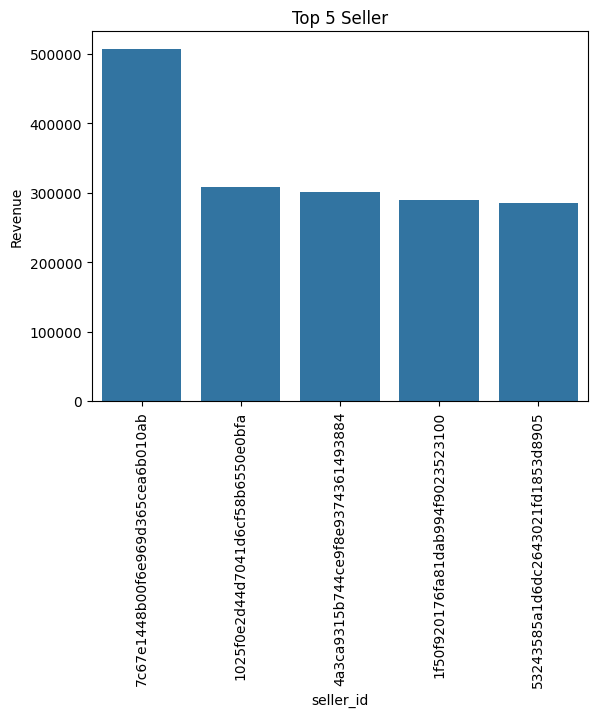

In [16]:
query="""select *, dense_rank() over (order by Revenue desc) as rn from
(SELECT order_items.seller_id, sum(payments.payment_value)
Revenue from order_items join payments
on order_items.order_id= payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["seller_id","Revenue", "rank"])
df=df.head()
sns.barplot(x= "seller_id", y= "Revenue", data=df)
plt.xticks(rotation=90)
plt.title("Top 5 Seller")
plt.show()

## 11 . Calculate the moving average of order values for each customer over their order history.

In [17]:
query=""" SELECT customer_id, order_Purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_Purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","Timestamp", "price", "moving_avg"])
df

,customer_id,Timestamp,price,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
311653,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
311654,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
311655,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
311656,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


## 12. Calculate the cumulative sales per month for each year.

In [18]:
query="""SELECT years, months, payment, 
  SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
      YEAR(orders.order_purchase_timestamp) AS years,
      MONTH(orders.order_purchase_timestamp) AS months,
      ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months
    ORDER BY years, months
) AS a;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Year", "Month","Sale","Cumulative_sales"])
# Combine year and month into a single date column for plotting
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# Check the updated DataFrame
df

,Year,Month,Sale,Cumulative_sales,Date
0,2016,9,756.72,756.72,2016-09-01
1,2016,10,177271.44,178028.16,2016-10-01
2,2016,12,58.86,178087.02,2016-12-01
3,2017,1,415464.12,593551.14,2017-01-01
4,2017,2,875724.03,1469275.17,2017-02-01
5,2017,3,1349590.80,2818865.97,2017-03-01
6,2017,4,1253364.09,4072230.06,2017-04-01
7,2017,5,1778756.46,5850986.52,2017-05-01
8,2017,6,1533829.14,7384815.66,2017-06-01
9,2017,7,1777148.76,9161964.42,2017-07-01


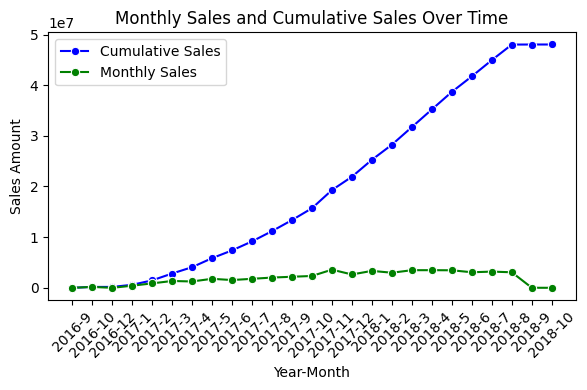

In [19]:
plt.figure(figsize=(6, 4))

# Create a combined string for "Year-Month" for better visualization
df['Year_Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
sns.lineplot(data=df, x='Year_Month', y='Cumulative_sales', marker='o', label='Cumulative Sales', color='blue')
sns.lineplot(data=df, x='Year_Month', y='Sale', marker='o', label='Monthly Sales', color='green')
plt.title('Monthly Sales and Cumulative Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 13. Calculate the year-over-year growth rate of total sales.

In [20]:
query = """WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years
    ORDER BY years
)
SELECT 
    years, 
    ((payment - LAG(payment, 1) OVER (ORDER BY years)) / LAG(payment, 1) OVER (ORDER BY years)) * 100 AS yoy_growth
FROM a;"""

cur.execute(query)
data = cur.fetchall()

# Create the DataFrame
df = pd.DataFrame(data, columns=["Years", "YoY Growth %"])
df


,Years,YoY Growth %
0,2016,NaN
1,2017,12112.703756
2,2018,20.000924


## 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [8]:
query="""WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) first_order
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT a.customer_id, 
           COUNT(DISTINCT orders.order_purchase_timestamp) next_order
    FROM a join orders
    ON orders.customer_id = a.customer_id
    and orders.order_purchase_timestamp > first_order
    AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT 100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id))
FROM a
LEFT JOIN b ON a.customer_id = b.customer_id;"""

cur.execute(query)
data = cur.fetchall()

x=f"percentage of customers who make another purchase within 6 months of their first purchase are: {data}"
print(x)

percentage of customers who make another purchase within 6 months of their first purchase are: [(None,)]


## 15. Identify the top 3 customers who spent the most money in each year.

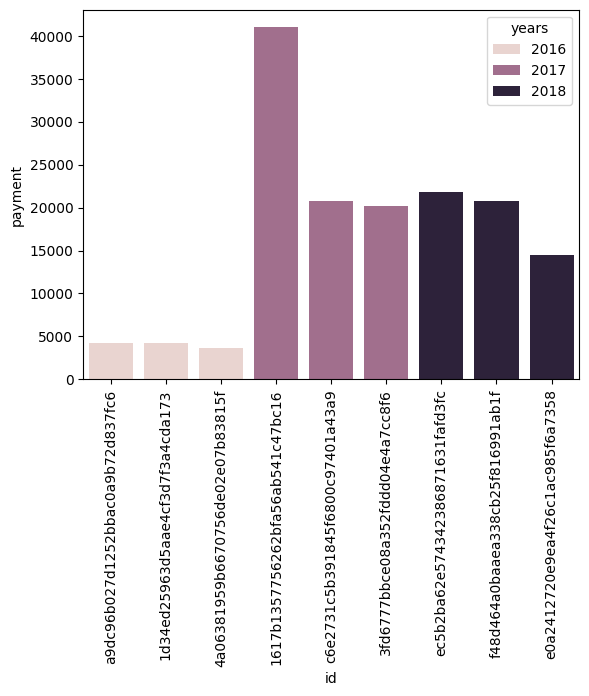

In [9]:
query="""select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()
